In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

NUM_CLASSES = 3
NUM_FEATS = 3
PREV_GAMES = 5
weight = np.array([.05, .1, .2, .3, .35])
#weight = [.15,.35,.5]
#weight = [.01,.04,.05,.1,.2,.3,.3]
dir_name = os.getcwd()
datasets = []
data_full = pd.DataFrame()
for suffix in ['16-17', '17-18', '18-19']:
    csv = dir_name + '/data/match_stats' +'_'+ suffix + '.csv' 
    dat = pd.read_csv(csv)
    datasets.append(dat)
    data_full = pd.concat((data_full, dat)).reset_index(drop=True)
data_full


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,13/08/16,Burnley,Swansea,0,1,A,0,0,D,...,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
1,E0,13/08/16,Crystal Palace,West Brom,0,1,A,0,0,D,...,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2,E0,13/08/16,Everton,Tottenham,1,1,D,1,0,H,...,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
3,E0,13/08/16,Hull,Leicester,2,1,H,1,0,H,...,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
4,E0,13/08/16,Man City,Sunderland,2,1,H,1,0,H,...,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,E0,12/05/2019,Liverpool,Wolves,2,0,H,1,0,H,...,2.31,22,-1.50,1.98,1.91,2.01,1.95,1.32,5.89,9.48
1136,E0,12/05/2019,Man United,Cardiff,0,2,A,0,1,A,...,2.95,21,-2.00,2.52,2.32,1.72,1.64,1.30,6.06,9.71
1137,E0,12/05/2019,Southampton,Huddersfield,1,1,D,1,0,H,...,2.29,22,-1.50,2.27,2.16,1.80,1.73,1.37,5.36,8.49
1138,E0,12/05/2019,Tottenham,Everton,2,2,D,1,0,H,...,2.07,19,-0.50,2.13,2.08,1.85,1.80,1.91,3.81,4.15


In [2]:
# get net scores
for data in datasets:
    data['goal_diff'] = data['FTHG'] - data['FTAG']
    data['shot_diff'] = data['HST'] - data['AST']
    data['corner_diff'] = data['HC'] - data['AC']

    print(data[data['FTR'] == 'D'].shape[0], data[data['FTR'] == 'A'].shape[0], data[data['FTR'] == 'H'].shape[0])

84 109 187
99 108 173
71 128 181


In [3]:
counter = {}
res = {}

def update_team_data(team, raw_dat, results, data_vec, is_away):
    '''
    Builds dictionary that maps a team to its weighted average score in three categories over Prev_Games.
    
    Parameters:
    team (str): team name
    raw_dat (dic): dictionary that maps a team its raw data over the past Prev_games
    results (dic): maps a team to its weighted average (over Prev_GAMES) score in three categories
    data_vec (np.array): the raw data. Columns 2-4 and 62-65 in the orginial dataframe.
    is_away (bool): Since the data is of the form Home-Away, we must reverse the sign when computing the
                    score of the away team.
    
    '''
    if is_away:
        sgn = -1
    else:
        sgn = 1
    if team not in raw_dat:
        raw_dat[team] = sgn * data_vec
    elif raw_dat[team].shape[0] < PREV_GAMES:
        raw_dat[team] = np.vstack((raw_dat[team], sgn * data_vec))
    else:
        results[team] = dict(zip(['goal', 'shot', 'corner'], np.average(raw_dat[team].astype('float'), axis=0, weights=weight)))
        raw_dat[team] = np.vstack((raw_dat[team][1:,], sgn * data_vec))
   
    return results
        


def get_avg_diff(row, dic, results):
    '''
    Creates a list containing the difference between the home team and the away team in
    the three categories from the results dictionary
    
    Parameters:
    row (series): A row of the form (home team name, away team name, goal diff, shot diff, corner diff)
    dic: Dictionary that maps a team its raw data over the past Prev_games
    results (dic): Maps a team to its weighted average (over Prev_GAMES) score in three categories
    
    returns:
    diff (lst): list of length 3 containing the difference between the home team and the away team in
    the three categories from the results dictionary
    
    
    '''
    update_team_data(row[0], dic, results, row[2:5], False)
    res = update_team_data(row[1], dic, results, row[2:5], True)
    #print(res.keys())
    if row[0] in res and row[1] in res:
        diff = []
        for key in results[row[0]].keys():
            diff.append(results[row[0]][key] - results[row[1]][key])
            
        return diff
    
    return [0,0,0]



#Create feature matrix
X_mat = pd.DataFrame()
y = pd.DataFrame()
for data in datasets:
    X_mat = pd.concat((X_mat, data.iloc[:,np.r_[2:4, 62:65]].apply(
        get_avg_diff, axis=1, dic=counter, results=res, result_type='expand').iloc[10 * PREV_GAMES:,].reset_index(drop=True))).reset_index(drop=True)
    label_encoder = preprocessing.LabelEncoder()
    y = pd.concat((y, pd.DataFrame(label_encoder.fit_transform(data.iloc[10 * PREV_GAMES:,6].reset_index(drop=True))))).reset_index(drop=True)
X_mat.columns = ['goals', 'shots', 'corners']
y.columns = ['Result']
np.corrcoef(X_mat.T)


array([[ 1.        ,  0.37070243, -0.1958627 ],
       [ 0.37070243,  1.        ,  0.72807928],
       [-0.1958627 ,  0.72807928,  1.        ]])

In [4]:
#Split data into training, validation, and test sets

tr, val, tst = np.split(pd.concat((X_mat,y),axis=1).sample(frac=1, random_state=42),
                         [int(len(X_mat) * .6), int(len(X_mat) * .8)])
X_tr = tr.iloc[:,:3]
y_tr = tr.iloc[:,3]
X_val = val.iloc[:,:3]
y_val = val.iloc[:,3]
X_tst = tst.iloc[:,:3]
y_tst = tst.iloc[:,3]


In [5]:
def tune_hyperparams(mod, Xtr, ytr, Xval, yval, param_grid, fit_param_dic):
    '''
    Fits model for each element in the cartesian product of the lists of possible values of each parameter
    given by the param_grid. Then selects the best model based on the validation accuracy.
    
    Parameters:
    mod (obj): A multiclass classifier
    Xtr (np.array): training data
    ytr (np.array): 1D array of training labels
    Xval (np.array): validation data
    yval (np.array): 1D array of validation labels
    param_grid (dic): maps each parameter to a list of values to be tested
    fit_param_dic (dic): used to implement early stopping for xgboost. Is an empty dictionary for all other classifiers
    
    Returns:
    validation_scores (dic): maps a given combination of parameters to the validation score for that model
    best_params_dic (dic): maps the parameter to its optimals value
    
    
    '''
    validation_scores = {}
    keys, vals = zip(*sorted(param_grid.items()))
    for it, params in enumerate(itertools.product(*vals)):
        #print(dict(zip(keys, params)))
        if it % 50 == 0:
            print(it, params)
        mod.set_params(**dict(zip(keys, params)))
        pipe = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), ('clf', mod)])
        pipe.fit(Xtr, ytr, **fit_param_dic)
        validation_scores[params] = log_loss(y_val, pipe.predict_proba(X_val), labels=y_val)
    best_params = min(validation_scores, key=validation_scores.get)
    best_params_dic = dict(zip(keys, best_params))
    
    return validation_scores, best_params_dic

0 (0.01, 0, 0, 2, 7, 500, 3, 'multi:softmax', 0.7)
{'eta': 0.01, 'gamma': 0, 'lambda': 0, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 500, 'num_class': 3, 'objective': 'multi:softmax', 'subsample': 0.7}
0 (1.0, 0.001, 'rbf', 1)
{'C': 1.0, 'gamma': 0.001, 'kernel': 'rbf', 'probability': 1}
0 (0.001, 'multinomial', 'sag')
50 (0.0015863565335085897, 'multinomial', 'sag')
100 (0.002516527051405392, 'multinomial', 'sag')
150 (0.003992109129748053, 'multinomial', 'sag')
200 (0.006332908400455114, 'multinomial', 'sag')
250 (0.010046250617173407, 'multinomial', 'sag')
300 (0.015936935303817745, 'multinomial', 'sag')
350 (0.025281661443314993, 'multinomial', 'sag')
400 (0.04010572880855496, 'multinomial', 'sag')
450 (0.06362198492657485, 'multinomial', 'sag')
{'C': 0.1, 'multi_class': 'multinomial', 'solver': 'sag'}


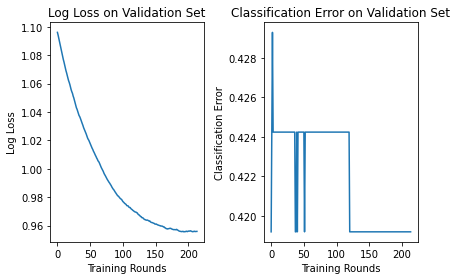

[18:07:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5404040404040404 1.00348789628708 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=0, learning_rate=0.00999999978, max_delta_step=0,
              max_depth=2, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=None,
              subsample=0.7, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)
0.5404040404040404 

Pipeline(steps=[('scaler', StandardScaler()),
                ('softmax',
                 LogisticRegression(C=0.1, multi_class='multinomial',
                                    solver='sag'))])

In [6]:
#Note parameters were tuned one, or two at time to cut down on computation time, so the grid does not reflect all values 
#tested

def model_select_sklearn(param_grid, mods, X_tr, y_tr, X_val, y_val):
    '''
    For each model class under consideration, the hyperparameters are tuned to find the best model within
    the class. The best models of each class are refit on the training and validation sets and the test error is
    computed and the model with the highest test accuracy is chosen.
    
    Parameters:
    param_grid (dic): maps each parameter to a list of values to be tested
    mods (lst): list of multiclass classifiers
    Xtr (np.array): training data
    ytr (np.array): 1D array of training labels
    Xval (np.array): validation data
    yval (np.array): 1D array of validation labels
    
    Returns:
    best_mod (obj): the model with the highest test accuracy
    '''
    optimal_mods = []
    for name, mod in mods:
        fit_params = {}
        if name == 'xgb':
            fit_params = {'clf__early_stopping_rounds': 20, 'clf__eval_set': [(X_val.values, y_val.values)], 
                          'clf__eval_metric':['merror','mlogloss'], 'clf__verbose':False}
        val_scores, best_params = tune_hyperparams(mod, X_tr, y_tr, X_val, y_val, param_grids[name], fit_params)
        print(best_params)
        pipe = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), (name, mod.set_params(**best_params))])
        optimal_mods.append(pipe)
    plot_xgb(optimal_mods[0]['xgb'])
    top_logloss = np.inf
    for mod in optimal_mods:
        mod.fit(pd.concat((X_tr, X_val)), pd.concat((y_tr, y_val)))  #refit best models on training and validation sets
        test_acc = mod.score(X_tst, y_tst)
        test_logloss = log_loss(y_tst, mod.predict_proba(X_tst), labels=y_tst)
        print(test_acc, test_logloss, mod[1])
        if test_logloss <= top_logloss:
            best_mod = mod
            top_logloss = test_logloss
    
    return best_mod


def plot_xgb(mod):
    '''
    Plots the validation error at each epoch during the training of an xgboost model
    '''
    fig, ax = plt.subplots(1,2)
    eval_res = mod.evals_result()
    ax[0].plot(range(0, len(eval_res['validation_0']['mlogloss'])), eval_res['validation_0']['mlogloss'])
    ax[1].plot(range(0, len(eval_res['validation_0']['merror'])), eval_res['validation_0']['merror'])
    ax[0].set(xlabel = 'Training Rounds', ylabel = 'Log Loss')
    ax[1].set(xlabel='Training Rounds', ylabel='Classification Error')
    ax[0].set_title('Log Loss on Validation Set')
    ax[1].set_title('Classification Error on Validation Set')
    plt.tight_layout()
    plt.show()   


param_grids = {'xgb': 
               {'subsample': [.7] , 
                'gamma': [0],
                'lambda': [0], 
                'eta': [.01], 'n_estimators': [500],
                'min_child_weight': [7], 'max_depth': [2],
                'objective': ['multi:softmax'],
                'num_class': [3] 
               },
               'svc':
               {'C': np.logspace(0,3,4), 'gamma': np.geomspace(1e-3,1,5), 'kernel':['rbf'], 'probability':[1]},
               'softmax': 
               {'C': np.geomspace(1e-3, 1e-1, 500), 'multi_class': ['multinomial'], 'solver': ['sag']} 
            }
mods = [('xgb', XGBClassifier(use_label_encoder=False)), ('svc', SVC()), ('softmax', LogisticRegression())]

best_mod_sklearn = model_select_sklearn(param_grids, mods, X_tr, y_tr, X_val, y_val)
best_mod_sklearn


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ray import tune
import torchvision.transforms as transforms
from functools import partial


In [8]:
class Net(nn.Module):
    '''
    Defines a feedforward neural network where each layer is a compostion of an affine function with 
    a nonlinear activation function that is applied elementwise. Dropout is applied to each layer except the output
    layer for regularization purposes.
    
    Attributes:
    linears: the linear layers
    output: the ouput layer
    activation: the activation function
    dropout: applies dropout
    '''
    def __init__(self, depth, width, activation, prob, num_classes):
        '''
        Constructor
        
        Parameters:
        depth (int): the number of layers
        width (int): the number of units in each layer
        activation (torch.nn): the activation function (same one used for each layer)
        prob (float): the probability with which a neuron has its outgoing connections killed in a dropout layer
        num_classes (int): the number of classes in our classification problem
            
        '''
        super(Net, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(width, width) if i!= 0 else nn.Linear(
            NUM_FEATS, width) for i in range(depth)])
        self.output = nn.Linear(width, num_classes)
        self.activation = activation
        #self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(prob) 
    
    def forward(self, x):
        for l in self.linears:
            x = self.dropout(self.activation(l(x)))
        x = self.output(x)
        #x = self.softmax(x)
        
        return x

class MatchData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(MatchData, self).__init__()
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.int64)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index,], self.y[index]


def normalize(X, mu, sd):
    '''
    Normalizes X by subtracting MU and dividing by SD
    '''
    return (X - mu) / sd


def compute_acc(labels, outputs):
    '''
    Converts raw ouput from network to a class prediction and computes accuracy relative to 
    true labels
    '''
    preds = torch.argmax(outputs.data, 1)
    
    return (preds == labels).sum() / labels.size(0)


def train_nn(param_grid, criterion=None, X_tr=None, y_tr=None, X_val=None, y_val=None, checkpoint_dir=None):
    '''
    Trains neural net with a particular configuration of hyperparameters given by the param grid.
    At each epoch the validation loss and accuracy is reported to ray tune.
    
    Parameters:
    param_grid (dic): maps hyperparameters to the particular value being tested
    Xtr (np.array): training data
    ytr (np.array): 1D array of training labels
    Xval (np.array): validation data
    yval (np.array): 1D array of validation labels
    '''
    net = Net(param_grid['depth'], param_grid['width'], param_grid['activation'], param_grid['prob'], NUM_CLASSES)
    #criterion = nn.CrossEntropyLoss()
    if param_grid['activation'] == 'nn.PReLU()':
        optimizer = optim.Adam([
            {'params': net.activation.parameters(), 'weight_decay':0},
            {'params': net.linears.parameters()},
            {'params': net.output.parameters()}
        ],
            lr=param_grid['lr'], weight_decay=param_grid['weight_decay'])
    else:
        optimizer = optim.Adam(net.parameters(), lr=param_grid['lr'],
                         weight_decay= param_grid['weight_decay'])
    if checkpoint_dir:
        mod_state, optim_state = torch.load(os.path.join(checkpoint_dir, 'checkpoint'))
        net.load_state_dict(mod_state)
        optimizer.load_state_dict(optim_state)
    trainset = MatchData(X_tr, y_tr)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=param_grid['batch'], 
                                              shuffle=True)
    
    for epoch in range(param_grid['epochs']):
        train_loop(trainloader, optimizer, criterion, net)
        with torch.no_grad():
            net.eval()
            val_labels = torch.tensor(y_val.values, dtype=torch.int64)
            val_outputs = net(torch.tensor(X_val.values, dtype=torch.float32))
            val_loss = criterion(val_outputs, val_labels).item()
            val_acc = compute_acc(val_labels, val_outputs)
            net.train()
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, 'checkpoint')
            torch.save((net.state_dict(), optimizer.state_dict()), path)
            
        tune.report(loss=val_loss, acc=val_acc)

def train_loop(trainloader, optimizer, criterion, net):
    '''
    Loops over training data and updates the weights according the optimzation algorithm
    
    Parameters:
    trainloader: allows for iterating over the training set in batches
    optimizer: implements optimzation algorithm used, controls weight update
    criterion: defines the loss function that is being optimized
    net: the model 
    '''
    
    running_loss = 0
    for idx, batch in enumerate(trainloader):
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print(epoch, running_loss)


        
def model_select_nn(param_grid, criterion, scheduler, num_trials, X_tr, y_tr, X_val, y_val, X_tst, y_tst):
    '''
    Uses tune to draw samples of hyperparam configurations from the search space defined by 
    the parameter grid and fits a model for each sample. The model with the lowest validation loss
    is chosen and is retrained on both the training and validation set. The test accuracy is reported.
    
    Parameters:
    param_grid (dic): maps hyperparam to a distribution to draw samples from
    scheduler: algorithm used to implement early stopping and peturb hyperparams
    num_trials (int): the number of samples to draw
    Xtr (np.array): training data
    ytr (np.array): 1D array of training labels
    Xval (np.array): validation data
    yval (np.array): 1D array of validation labels
    Xtst (np.array): test data
    ytst (np.array): 1D array of test labels
    '''
    reporter = tune.JupyterNotebookReporter(metric_columns = ['loss', 'acc', 'training_iteration'], overwrite=1)
    res = tune.run(partial(train_nn, criterion=criterion, X_tr=X_tr, y_tr=y_tr, X_val=X_val, y_val=y_val),
             resources_per_trial={'cpu':4, 'gpu': 0},
             config=param_grid,
             scheduler=scheduler,
             progress_reporter=reporter,
             num_samples=num_trials)
    best_trial = res.get_best_trial('loss', 'min')
    print(best_trial.config)
    best_mod = Net(best_trial.config['depth'], best_trial.config['width'], best_trial.config['activation'],
                  best_trial.config['prob'], NUM_CLASSES)
    #best_checkpoint_dir = best_trial.checkpoint.value
    #mod_state, optim_state = torch.load(os.path.join(best_checkpoint_dir, 'checkpoint'))
    #best_mod.load_state_dict(mod_state)
    train_val_set = MatchData(pd.concat((X_tr, X_val)), pd.concat((y_tr, y_val)))
    train_val_loader = torch.utils.data.DataLoader(train_val_set, batch_size=best_trial.config['batch'],
                                                  shuffle=True)
    
    if best_trial.config['activation'] == 'nn.PReLU()':
        optimizer = optim.Adam([
            {'params': best_mod.activation.parameters(), 'weight_decay':0},
            {'params': best_mod.linears.parameters()},
            {'params': best_mod.output.parameters()}
        ],
            lr=best_trial.config['lr'], weight_decay=best_trial.config['weight_decay'])
    else:
        optimizer = optim.Adam(best_mod.parameters(), lr=best_trial.config['lr'],
                         weight_decay=best_trial.config['weight_decay'])
    
    for epoch in range(best_trial.config['epochs']):
        train_loop(train_val_loader, optimizer, criterion, best_mod)  
    best_mod.eval()
    with torch.no_grad():
        test_labels = torch.tensor(y_tst.values, dtype=torch.int64)
        test_outputs = best_mod(torch.tensor(X_tst.values, dtype=torch.float32))
        print(compute_acc(test_labels, test_outputs))
        print(criterion(test_outputs, test_labels).item())
    
    return best_mod


MU = np.mean(X_tr)
SD = np.sqrt(np.diag(np.cov(X_tr.T)))
X_tr = normalize(X_tr, MU, SD)
X_val = normalize(X_val, MU, SD)
X_tst = normalize(X_tst, MU, SD)

param_grid = {
    'depth': tune.randint(1, 5),
    'width': tune.randint(3, 15),
    'activation': tune.choice([nn.ReLU(), nn.PReLU()]),
    'epochs': tune.choice([10, 25, 40, 50, 75, 150]),
    'batch': tune.choice([2**i for i in range(1, 4)]),
    'lr': tune.loguniform(1e-4, 1e-1),
    #'momentum': tune.uniform(.9, .99),
    'prob': tune.uniform(.075,.25),
    'weight_decay':tune.uniform(1e-6, 1e-3)
}

'''
param_grid = {
    'depth': tune.randint(5,7),
    'width': tune.randint(8, 11),
    'activation': tune.choice([nn.ReLU(), nn.PReLU()]),
    'epochs': tune.choice([30, 40, 50, 75, 100 ,150]),
    'batch': tune.choice([2**i for i in range(1,3)]),
    'lr': tune.loguniform(1e-4, 1e-2),
    #'momentum': tune.uniform(.95, .99),
    'prob': tune.uniform(.05, .25),
    'weight_decay': tune.uniform(1e-5, 1e-3)
}
'''
scheduler = tune.schedulers.ASHAScheduler(metric = 'loss', mode='min')
num_trials = 100
loss = nn.CrossEntropyLoss()
best_mod_nn = model_select_nn(param_grid, loss, scheduler, num_trials, X_tr, y_tr, X_val, y_val, X_tst, y_tst)


Trial name,status,loc,activation,batch,depth,epochs,lr,prob,weight_decay,width,loss,acc,training_iteration
DEFAULT_849f2_00000,TERMINATED,,ReLU(),4,2,75,0.0049516,0.0786896,0.000583578,9,0.914671,0.585859,75
DEFAULT_849f2_00001,TERMINATED,,ReLU(),8,3,40,0.00527951,0.101202,0.000715286,13,0.946856,0.570707,1
DEFAULT_849f2_00002,TERMINATED,,PReLU(num_parameters=1),2,3,10,0.000969036,0.226066,0.000129504,14,1.03405,0.494949,1
DEFAULT_849f2_00003,TERMINATED,,PReLU(num_parameters=1),2,1,40,0.0029182,0.238349,0.000540822,3,0.949633,0.590909,1
DEFAULT_849f2_00004,TERMINATED,,ReLU(),4,2,50,0.00285815,0.123846,0.000488357,11,0.931532,0.575758,16
DEFAULT_849f2_00005,TERMINATED,,PReLU(num_parameters=1),4,2,40,0.0409739,0.23311,0.000508695,11,1.10722,0.388889,1
DEFAULT_849f2_00006,TERMINATED,,ReLU(),8,4,150,0.00118552,0.0919049,0.000116877,4,1.03823,0.484848,1
DEFAULT_849f2_00007,TERMINATED,,ReLU(),8,4,150,0.0991656,0.106308,0.000403937,8,1.04524,0.484848,1
DEFAULT_849f2_00008,TERMINATED,,PReLU(num_parameters=1),8,4,150,0.000468415,0.0818029,0.000637406,10,1.07351,0.5,1
DEFAULT_849f2_00009,TERMINATED,,ReLU(),4,2,50,0.000901746,0.0926957,0.000986657,8,1.00565,0.50505,1


2021-05-06 18:13:57,795	INFO tune.py:450 -- Total run time: 361.74 seconds (358.40 seconds for the tuning loop).


{'depth': 2, 'width': 9, 'activation': ReLU(), 'epochs': 75, 'batch': 4, 'lr': 0.004951597989418886, 'prob': 0.07868960807634182, 'weight_decay': 0.0005835784937656156}


/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


tensor(0.5303)
0.9999739527702332


In [9]:
def simple_strat(row):
    '''
    Defines a simple betting strategy where 1 dollar is bet on the outcome with the highest probability
    
    Parameters: row containing prediction, true result and betting information
    
    Returns: 1 if bet is lost, and the payout given by the odds if won   
    '''
    if row[0] != row[1]:
        return -1 
    if row[0] == 'H':
        return row[4]
    elif row[0] == 'A':
        return row[6]
    else:
        return row[5]

MIN_PROB = .45
FACTOR = 5
def conservative_strat(row):
    '''
    Defines a betting strategy where a bet is placed only if the probability associated with the most likely class is
    .5 or greater. If a bet is made, the wager is proportional to the product of the probability and some constant.
    
    Parameters: row containing prediction, true result and betting information
    
    Returns: 1 if bet is lost, and the payout given by the odds if won    
    '''
    if row[2] >= MIN_PROB:
        wager = round(row[2] * FACTOR, 2)
        if row[0] != row[1]:
            return -wager
        elif row[0] == 'H':
            return row[4] * wager
        elif row[0] == 'A':
            return row[6] * wager
        else:
            return row[5] * wager
    else:
        return 0

In [10]:
ypred = best_mod_sklearn.predict(X_tst)
ys = np.vstack((ypred, y_tst))
ys = np.where(ys==2,'H', np.where(ys==0, 'A', 'D')) #convert back to original labels
probs = np.max(best_mod_sklearn.predict_proba(X_tst), axis=1)
pred_target_prob = pd.DataFrame(np.vstack((ys, probs)).T, columns=['ypred', 'ytest', 'predicted_prob'])
pred_target_prob = pred_target_prob.astype({'predicted_prob': float})
odds = data_full.iloc[10 * PREV_GAMES:,23:26].reset_index(drop=True).iloc[y_tst.index].reset_index()
winnings_dat = pd.concat((pred_target_prob, odds), axis=1)
#print(winnings_dat)

for strat in [simple_strat, conservative_strat]:
    winnings_dat['winnings'] = winnings_dat.apply(strat, axis=1)
    print(sum(winnings_dat['winnings']))
    print(winnings_dat)
    print(winnings_dat.iloc[winnings_dat['winnings'].idxmax(),:])


226.86999999999995
    ypred ytest  predicted_prob  index  B365H  B365D  B365A  winnings
0       H     A        0.540128    947   1.22   7.00  15.00     -1.00
1       H     H        0.522692    577   1.75   3.50   6.00      1.75
2       H     H        0.518012     85   2.20   3.30   3.75      2.20
3       H     D        0.535021    242   2.00   3.40   4.33     -1.00
4       H     H        0.578267    698   1.18   8.50  17.00      1.18
..    ...   ...             ...    ...    ...    ...    ...       ...
193     H     A        0.431296    106  10.00   5.75   1.33     -1.00
194     H     H        0.546911    270   2.55   3.20   2.80      2.55
195     H     A        0.455690    860   1.28   6.00  12.00     -1.00
196     H     H        0.556703    435   5.25   4.33   1.66      5.25
197     H     A        0.483278    102   5.25   4.00   1.70     -1.00

[198 rows x 8 columns]
ypred                    H
ytest                    H
predicted_prob    0.459366
index                  546
B365H    